In [243]:
import pandas as pd
import numpy as np
import random
import math

from scipy.stats import mannwhitneyu, normaltest, ttest_rel, wilcoxon
import matplotlib.pyplot as plt

# Analyze data with new labels
- covers P2/P3 of homepage, rank 1-10 on the homepage
- uses automatic labels from channel lists and manual labels combined from all previous labeling iterations with consistent codebook
- perform mwu test, and watched/inferred test

## Get data with on/off-topic labels

In [244]:
topics = ['alt-right', 'antitheist', 'politics-left', 'politics-right']
strategies = ['none','watch','delete','dislike','not-interested','no-channel','dislike-recommendation']


In [245]:
df = pd.read_csv('bot_runs_labeled_1-4.csv')
df.head()

,video_id,channel_id,rank,component,watch_video_id,bot_name,phase,homepage_level,videopage_level,topic,strategy,note,on_list,manual_label_1-4,exp_stage,on_topic
0,ohjsypZfFVg,UCkY8CvV8WQFe87CZGmvuYHA,0,homepage,NaN,alt-right_delete_0,stain,1,2,alt-right,delete,0,True,NaN,1,True
1,3zlvqFcinr8,UCXHcH4CggCrvIpm0KM0kHQg,1,homepage,NaN,alt-right_delete_0,stain,1,2,alt-right,delete,0,False,False,1,False
2,9Xd8xq06FCw,UCCND6a0H56zHL4YuY226ZOQ,2,homepage,NaN,alt-right_delete_0,stain,1,2,alt-right,delete,0,False,False,1,False
3,sLTvQnjEkRU,UCAaZm4GcWqDg8358LIx3kmw,3,homepage,NaN,alt-right_delete_0,stain,1,2,alt-right,delete,0,False,False,1,False
4,PmNyNJFCugo,UCvrmr8Nfd86dG7pnSHC7c6Q,4,homepage,NaN,alt-right_delete_0,stain,1,2,alt-right,delete,0,False,False,1,False


In [246]:
df[df['component']=='videopage']['exp_stage'].unique()

array([1, 2, 3])

## Watched before vs. inferred labeling

In [247]:
vid_channel_dicts = {}
channels_dict = {}

# Video ID's in sample video lists don't contain Channel ID's
# We make a dict of them here

videos_df = pd.read_csv('../../seed_data_generation/politics/all_videos.csv')
videos_df.set_index('vid', inplace=True)
# Make sure it's only the left videos
videos_df = videos_df[videos_df.channel_ideology=='L']
vid_channel_dict = videos_df.to_dict(orient='index')
videos_df.head()
vid_channel_dicts['politics-left'] = vid_channel_dict

videos_df = pd.read_csv('../../seed_data_generation/politics/all_videos.csv')
videos_df.set_index('vid', inplace=True)
# Make sure it's only the right videos
videos_df = videos_df[videos_df.channel_ideology=='R']
vid_channel_dict = videos_df.to_dict(orient='index')
videos_df.head()
vid_channel_dicts['politics-right'] = vid_channel_dict

videos_df = pd.read_csv('../../seed_data_generation/antitheist/videos.csv')
videos_df.set_index('vid', inplace=True)
vid_channel_dict = videos_df.to_dict(orient='index')
videos_df.head()
vid_channel_dicts['antitheist'] = vid_channel_dict

videos_df = pd.read_csv('../../seed_data_generation/alt-right/videos.csv')
videos_df.set_index('vid', inplace=True)
vid_channel_dict = videos_df.to_dict(orient='index')
videos_df.head()
vid_channel_dicts['alt-right'] = vid_channel_dict

videos_df = pd.read_csv('../../seed_data_generation/alt-right/videos.csv')
videos_df.set_index('vid', inplace=True)
vid_channel_dict = videos_df.to_dict(orient='index')
videos_df.head()
vid_channel_dicts['alt-right'] = vid_channel_dict

videos_df = pd.read_csv('../../seed_data_generation/random/videos.csv')
videos_df.set_index('vid', inplace=True)
vid_channel_dict = videos_df.to_dict(orient='index')
videos_df.head()
vid_channel_dicts['random'] = vid_channel_dict

channels_df = pd.read_csv('../../seed_data_generation/politics/channels_left.csv', header=None)
channels_dict['politics-left'] = set(channels_df[0])

channels_df = pd.read_csv('../../seed_data_generation/politics/channels_right.csv', header=None)
channels_dict['politics-right'] = set(channels_df[0])

channels_df = pd.read_csv('../../../burst/communities/antitheist/antitheist_channels.csv', header=None)
channels_dict['antitheist'] = set(channels_df[0])

channels_df = pd.read_csv('../../seed_data_generation/alt-right/alt-right_channels.csv', header=None)
channels_dict['alt-right'] = set(channels_df[0])

channels_df = pd.read_csv('../../seed_data_generation/random/random_channels.csv', header=None)
channels_dict['random'] = set()

In [248]:
all_levels_df = pd.read_csv('../all_cleaned_labeled.csv')
all_levels_df.rename(columns={'stain':'on_list'},inplace=True)
all_levels_df.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,video_id,channel_id,rank,component,watch_video_id,bot_name,phase,phase_level,homepage_level,videopage_level,time,topic,strategy,note,rerun,on_list,channel_type
0,0,0,0,PEWFu0aZroQ,UCXIJgqnII2ZOINSWNOGFThA,0,videopage,ya2T1XGYTR8,alt-right_delete_0,videopage_experiment,0,0,0,2022-08-07 04:54:08.682177,alt-right,delete,0,0,False,off-list
1,1,1,1,XmiG4KzZ4sg,UCPKAKrjoMz7POptCloy7AIQ,1,videopage,ya2T1XGYTR8,alt-right_delete_0,videopage_experiment,0,0,0,2022-08-07 04:54:08.682192,alt-right,delete,0,0,False,off-list
2,2,2,2,Lh0b00vL1nI,UCmRZTrJYqOMzP5J0r0snxYg,2,videopage,ya2T1XGYTR8,alt-right_delete_0,videopage_experiment,0,0,0,2022-08-07 04:54:08.682195,alt-right,delete,0,0,False,off-list
3,3,3,3,k6ucIShHW7Q,UCJquYOG5EL82sKTfH9aMA9Q,3,videopage,ya2T1XGYTR8,alt-right_delete_0,videopage_experiment,0,0,0,2022-08-07 04:54:08.682199,alt-right,delete,0,0,False,off-list
4,4,4,4,0GCDhADokLY,UC2ggrxKhqgTRx7We9vjQRCQ,4,videopage,ya2T1XGYTR8,alt-right_delete_0,videopage_experiment,0,0,0,2022-08-07 04:54:08.682202,alt-right,delete,0,0,False,off-list


## P2 analysis for watched vs. not watched topical recommendations

In [249]:
watched=all_levels_df[all_levels_df['homepage_level']<39].groupby(['topic','bot_name'])['watch_video_id'].apply(
    lambda x: x[~x.isna()].unique()
)
watched

topic      bot_name          
alt-right  alt-right_delete_0    [ya2T1XGYTR8, 3MMP0LbNFyg, kPLKqePlyoU, 0N75MV...
           alt-right_delete_1    [tDzwWWL2Jw4, zGccmJjFY20, ozQfqLz4CzU, 6_FkuS...
           alt-right_delete_2    [P6vLOMEY-IA, x6Gxx-x-0Hc, n3fCFYZ-rv0, rcpxX5...
           alt-right_delete_3    [WIG_bVxgfJw, e5ivF5fnYP4, qvvBpCufHDw, _a2qms...
           alt-right_delete_4    [faNge-o0V-k, G5SGOKEDRKU, khjpRAz1x4k, x59xns...
                                                       ...                        
random     random_watch_0        [hpzsOvIX-dc, arMii4RyAtI, wH0sNfPGwZY, jlSVpp...
           random_watch_1        [rLTIJO7SA4M, xJ7s-ujkecA, pbX9DmaMpkU, 6iEzm0...
           random_watch_2        [4jG33HM2gTI, IA6SI_kx70U, PQRewpFkLlo, FLbDJt...
           random_watch_3        [1zEytekDbOs, 9WBm1KrWCOg, zYEkUG_WvUw, t9eirC...
           random_watch_4        [IeiPIINxgUs, 8AadtEbfs4o, zLrhvHFoSY4, -56Acc...
Name: watch_video_id, Length: 173, dtype: object

In [250]:
def watched_chans(x, topic):
    chans_list = set()
    for vid in x:
        chans_list.add(
            vid_channel_dicts[topic][vid]['cid']
        )
    return chans_list

In [251]:
watched = watched.reset_index()
watched['watched_chans'] = watched[['topic','watch_video_id']].apply(lambda x: watched_chans(x.watch_video_id,x.topic),axis=1)
watched.set_index(['bot_name'],inplace=True)
watched = watched['watched_chans']
watched

bot_name
alt-right_delete_0    {UCZtDKD0pFpPclXA7ZAti90w, UCN0-RRaxMgh86eOwnd...
alt-right_delete_1    {UCZtDKD0pFpPclXA7ZAti90w, UCN0-RRaxMgh86eOwnd...
alt-right_delete_2    {UCZtDKD0pFpPclXA7ZAti90w, UCN0-RRaxMgh86eOwnd...
alt-right_delete_3    {UCN0-RRaxMgh86eOwndAklxw, UCHC60upCUfq7EAfw6o...
alt-right_delete_4    {UCN0-RRaxMgh86eOwndAklxw, UC2w1CQqPli4w94-PCg...
                                            ...                        
random_watch_0        {UC_LDtFt-RADAdI8zIW_ecbg, UCm8Txl73DpLrwwM8GA...
random_watch_1        {UC_LDtFt-RADAdI8zIW_ecbg, UCm8Txl73DpLrwwM8GA...
random_watch_2        {UCm8Txl73DpLrwwM8GA5-T9w, UCFnvNS_FRRiNhWgsyt...
random_watch_3        {UC_LDtFt-RADAdI8zIW_ecbg, UCm8Txl73DpLrwwM8GA...
random_watch_4        {UC_LDtFt-RADAdI8zIW_ecbg, UCmpAzRl7A901u5KfHl...
Name: watched_chans, Length: 173, dtype: object

In [252]:
def get_channel_type_p2(x):
    if x.channel_id in watched[x.bot_name]:
        return 'on-topic watched-channel'
    if x.on_topic:
        return 'on-topic new-channel'
    return 'off-topic'

In [253]:
p2_hp_df = df[
    (df['exp_stage']==2)&
    (df['component']=='homepage')
]
p2_hp_df['channel_type'] = p2_hp_df[['bot_name','channel_id','on_topic']].apply(get_channel_type_p2,axis=1)


/var/folders/t6/srtzy2f51db8mxxv7g_63f6h0000gr/T/ipykernel_60591/2171590104.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p2_hp_df['channel_type'] = p2_hp_df[['bot_name','channel_id','on_topic']].apply(get_channel_type_p2,axis=1)


In [254]:
p2_vp_df = df[
    (df['exp_stage']==2)&
    (df['component']=='videopage')
]
p2_vp_df['channel_type'] = p2_vp_df[['bot_name','channel_id','on_topic']].apply(get_channel_type_p2,axis=1)


/var/folders/t6/srtzy2f51db8mxxv7g_63f6h0000gr/T/ipykernel_60591/360744544.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p2_vp_df['channel_type'] = p2_vp_df[['bot_name','channel_id','on_topic']].apply(get_channel_type_p2,axis=1)


In [255]:
p2_hp_watched = p2_hp_df.groupby('topic')['channel_type'].agg(
    off_topic = lambda x: (x=='off-topic').sum() / len(x), 
    on_topic_watched = lambda x: (x=='on-topic watched-channel').sum() / len(x),
    on_topic_new = lambda x: (x=='on-topic new-channel').sum() / len(x)
#    total = lambda x: len(x)
).apply(lambda y: y.apply(lambda z:'{0:.0f}%'.format(round(z*100)) if z<1 else z)).stack().reset_index().replace(
    {'on_topic_watched':'on-topic watched-channel', 'on_topic_new': 'on-topic new-channel'}
)
p2_hp_watched['component'] = ['homepage' for i in range(p2_hp_watched.shape[0])]

In [256]:
p2_vp_watched = p2_vp_df.groupby('topic')['channel_type'].agg(
    off_topic = lambda x: (x=='off-topic').sum() / len(x), 
    on_topic_watched = lambda x: (x=='on-topic watched-channel').sum() / len(x),
    on_topic_new = lambda x: (x=='on-topic new-channel').sum() / len(x)
#    total = lambda x: len(x)
).apply(lambda y: y.apply(lambda z:'{0:.0f}%'.format(round(z*100)) if z<1 else z)).stack().reset_index().replace(
    {'on_topic_watched':'on-topic watched-channel', 'on_topic_new': 'on-topic new-channel'}
)
p2_vp_watched['component'] = ['videopage' for i in range(p2_vp_watched.shape[0])]


In [257]:
p2_watched_final = pd.concat(
    [
        p2_hp_watched, p2_vp_watched
    ]
).rename(columns={'level_1': 'metric', 0:'ratio'}).set_index(['topic','component','metric']).unstack([0,2])

p2_watched_final

ratio                                                           \
topic     alt-right                                               antitheist   
metric    off_topic on-topic watched-channel on-topic new-channel  off_topic   
component                                                                      
homepage        82%                      16%                   2%        64%   
videopage       95%                       5%                   0%        82%   

                                                                       \
topic                                                   politics-left   
metric    on-topic watched-channel on-topic new-channel     off_topic   
component                                                               
homepage                       18%                  18%           75%   
videopage                       9%                  10%           69%   

                                                                        \
topic                                                   politics-right   
metric    on-topic watched-channel on-topic new-channel      off_topic   
component                                                                
homepage                        2%                  22%            71%   
videopage                      14%                  17%            75%   

                                                         
topic                                                    
metric    on-topic watched-channel on-topic new-channel  
component                                                
homepage                        9%                  21%  
videopage                      19%                   6%

In [258]:
p2_watched_final.to_csv('./tables/p2_watched_final.csv')

In [259]:
num_p2_watched_final = p2_watched_final.applymap(lambda x: int(x[:-1])/100)
num_p2_watched_final

ratio                                                           \
topic     alt-right                                               antitheist   
metric    off_topic on-topic watched-channel on-topic new-channel  off_topic   
component                                                                      
homepage       0.82                     0.16                 0.02       0.64   
videopage      0.95                     0.05                 0.00       0.82   

                                                                       \
topic                                                   politics-left   
metric    on-topic watched-channel on-topic new-channel     off_topic   
component                                                               
homepage                      0.18                 0.18          0.75   
videopage                     0.09                 0.10          0.69   

                                                                        \
topic                                                   politics-right   
metric    on-topic watched-channel on-topic new-channel      off_topic   
component                                                                
homepage                      0.02                 0.22           0.71   
videopage                     0.14                 0.17           0.75   

                                                         
topic                                                    
metric    on-topic watched-channel on-topic new-channel  
component                                                
homepage                      0.09                 0.21  
videopage                     0.19                 0.06

In [260]:
left = 0
height = .5
colors = ['tomato','pink','whitesmoke']
components = ['homepage', 'videopage']
plt.rcParams.update({'font.size': 16})

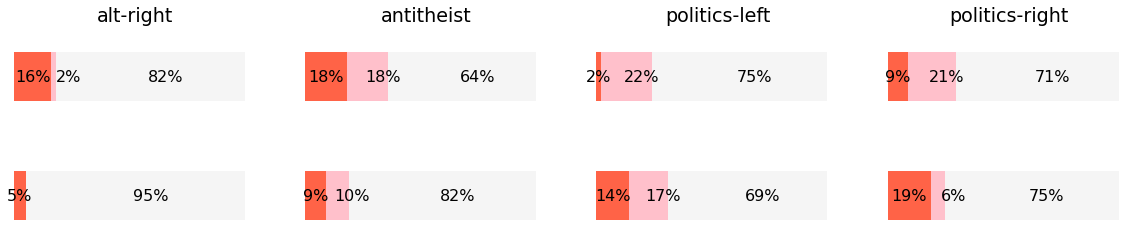

In [261]:
# Sources: 
# https://matplotlib.org/stable/gallery/pie_and_polar_charts/bar_of_pie.html
# https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.barh.html#matplotlib.axes.Axes.barh
fig, axs = plt.subplots(2, 4, figsize=(20, 4))
for comp_idx in range(len(axs)):
    component = components[comp_idx]
    for topic_idx in range(len(axs[comp_idx])):
        topic = topics[topic_idx]
        
        ax = axs[comp_idx][topic_idx]

        ratios = num_p2_watched_final.loc[(component,('ratio',topic,slice(None)))]['ratio',topic]
        # This is a hack; we got lucky that the alphabetical order followed our desired order
        ratios = ratios.sort_index(ascending=False)
        #print(ratios)

        # For colors
        i = 0
        prev_width = 10
        for j, (width, label) in enumerate([*zip(ratios, ratios.index)]):
            bc = ax.barh(0, width, height, left=left, color=colors[i], label=label)
            if width > 0:
                # Adjust padding so that if the previous number is small then this label doesn't overlap with it
                ax.bar_label(bc, labels=['{0}%'.format(round(width*100))], label_type='center', padding=15 if prev_width<10 else 0)
                prev_width = width
            i += 1    
            
            left += width

        if comp_idx==0:
            ax.set_title('{0}'.format(topic))
        ax.axis('off')
        ax.set_ylim(- 1 * height, 1 * height)

        # Won't work!
        if topic_idx==0:
            #print('yes')
            ax.set_ylabel('{0}'.format(component))

        #if comp_idx==0 and topic_idx==len(axs[comp_idx])-1:
            #ax.legend(loc = 'right')

plt.show()

## P3 analysis for explicit scrubbed vs. not, topical recommendations

In [262]:
scrubbed=all_levels_df[
    (all_levels_df['homepage_level']>39)&
    (all_levels_df['homepage_level']<79)&
    (all_levels_df['strategy'].isin(['dislike-recommendation','not-interested','no-channel']))&
    (all_levels_df['on_list'])
].groupby(['bot_name','homepage_level'])['channel_id'].agg('first')
scrubbed

bot_name                            homepage_level
alt-right_dislike-recommendation_0  40                UCkY8CvV8WQFe87CZGmvuYHA
                                    41                UCHC60upCUfq7EAfw6oDQRDA
                                    42                UCN0-RRaxMgh86eOwndAklxw
                                    44                UCLM6JlQkQ9tltBL9Bipci9g
                                    48                UCmrLCXSDScliR7q8AxxjvXg
                                                                ...           
random_not-interested_3             40                UC9Ed9JvjK_UDDpj8C_tMaqg
                                    41                UCY1gTTyBQ8m9ZoRpd7rgQCg
                                    42                UC5tkSsOxlr91yi30Rs5qtfg
                                    43                UCBjBZmguQzn6WCYR7DQykLw
                                    46                UC_LDtFt-RADAdI8zIW_ecbg
Name: channel_id, Length: 1042, dtype: object

In [263]:
scrubbed_chans = scrubbed.groupby('bot_name').agg(lambda x: set(x.unique()))
scrubbed_chans

bot_name
alt-right_dislike-recommendation_0    {UCN0-RRaxMgh86eOwndAklxw, UCHC60upCUfq7EAfw6o...
alt-right_dislike-recommendation_1    {UCZtDKD0pFpPclXA7ZAti90w, UCHC60upCUfq7EAfw6o...
alt-right_dislike-recommendation_2    {UCLM6JlQkQ9tltBL9Bipci9g, UCZtDKD0pFpPclXA7ZA...
alt-right_dislike-recommendation_3    {UCHC60upCUfq7EAfw6oDQRDA, UCN0-RRaxMgh86eOwnd...
alt-right_dislike-recommendation_4    {UCN0-RRaxMgh86eOwndAklxw, UCHC60upCUfq7EAfw6o...
                                                            ...                        
random_no-channel_4                   {UCZu9AV3mrCCDpK_dy1qJRAQ, UCZvMYyu8lODcgfU-3x...
random_not-interested_0               {UC_LDtFt-RADAdI8zIW_ecbg, UCIGAhiNRjFpBiYQyJ0...
random_not-interested_1               {UCSjlTrPYRxwiNzjGiuZm0pg, UCm8Txl73DpLrwwM8GA...
random_not-interested_2               {UCLo0YCIaSzmrZ6Nr_XwQWrw, UCm8Txl73DpLrwwM8GA...
random_not-interested_3               {UC_LDtFt-RADAdI8zIW_ecbg, UCBjBZmguQzn6WCYR7D...
Name: channel_id, Lengt

In [264]:
scrubbed_chans = pd.concat([scrubbed_chans, watched[set(watched.index) - set(scrubbed_chans.index)]])

/var/folders/t6/srtzy2f51db8mxxv7g_63f6h0000gr/T/ipykernel_60591/1408434099.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  scrubbed_chans = pd.concat([scrubbed_chans, watched[set(watched.index) - set(scrubbed_chans.index)]])


In [265]:
def get_channel_type_p3(x):
    if x.channel_id in watched[x.bot_name]:
        return 'on-topic scrubbed'
    if x.on_topic:
        return 'on-topic new'
    return 'off-topic'

In [266]:
p3_hp_df = df[
    (df['exp_stage']==3)&
    (df['component']=='homepage')&
    (df['strategy']!='none')
]
p3_vp_df = df[
    (df['exp_stage']==3)&
    (df['component']=='videopage')&
    (df['strategy']!='none')
]

p3_hp_df['channel_type'] = p3_hp_df[['bot_name','channel_id','on_topic']].apply(get_channel_type_p3,axis=1)
p3_vp_df['channel_type'] = p3_vp_df[['bot_name','channel_id','on_topic']].apply(get_channel_type_p3,axis=1)


/var/folders/t6/srtzy2f51db8mxxv7g_63f6h0000gr/T/ipykernel_60591/867851526.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p3_hp_df['channel_type'] = p3_hp_df[['bot_name','channel_id','on_topic']].apply(get_channel_type_p3,axis=1)
/var/folders/t6/srtzy2f51db8mxxv7g_63f6h0000gr/T/ipykernel_60591/867851526.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p3_vp_df['channel_type'] = p3_vp_df[['bot_name','channel_id','on_topic']].apply(get_channel_type_p3,axis=1)


In [267]:
def scrubbed_str(s):
    ot = 0
    ots = 0
    otns = 0
    
    if 'on-topic not-scrubbed' in s.keys():
        otns = s['on-topic not-scrubbed']
    if 'on-topic scrubbed' in s.keys():
        ots = s['on-topic scrubbed']
    if 'off-topic' in s.keys():
        ot = s['off-topic']
        
    ret_str = ''
    for i in range(round(ot*20)):
        ret_str += 'x'
    for i in range(round(ots*20)):
        ret_str += 'o'
    for i in range(round(otns*20)):
        ret_str += '+'
    
    return ret_str

In [268]:
def scrubbed_str_2(s):
    ot = 0
    ots = 0
    otns = 0
    
    if 'on-topic not-scrubbed' in s.keys():
        otns = s['on-topic not-scrubbed']
    if 'on-topic scrubbed' in s.keys():
        ots = s['on-topic scrubbed']
    if 'off-topic' in s.keys():
        ot = s['off-topic']
    
    return '{0:.0f}%,{1:.0f}%,{2:.0f}% ({3})'.format(round(ot*100),round(ots*100),round(otns*100),s['total'])

In [269]:
p3_hp_final = p3_hp_df.groupby(['topic','strategy'])['channel_type'].apply(
    lambda x: dict(x.value_counts(normalize=True)),
).fillna(0).apply(
    lambda x: '{0:.0f}%'.format(round(x*100))
).unstack([0,2]).loc[strategies[1:]]

p3_hp_final

topic                  alt-right                                antitheist  \
                       off-topic on-topic scrubbed on-topic new  off-topic   
strategy                                                                     
watch                        92%                8%           0%        80%   
delete                      100%                0%           0%        72%   
dislike                      98%                2%           0%        84%   
not-interested              100%                0%           0%        98%   
no-channel                   94%                0%           6%        84%   
dislike-recommendation       92%                2%           6%        92%   

topic                                                 politics-left  \
                       on-topic scrubbed on-topic new     off-topic   
strategy                                                              
watch                                14%           6%           82%   
delete                               18%          10%          100%   
dislike                              10%           6%           76%   
not-interested                        0%           2%           98%   
no-channel                            2%          14%           92%   
dislike-recommendation                0%           8%           82%   

topic                                                 politics-right  \
                       on-topic scrubbed on-topic new      off-topic   
strategy                                                               
watch                                 2%          16%            82%   
delete                                0%           0%            98%   
dislike                               0%          24%            84%   
not-interested                        0%           2%           100%   
no-channel                            0%           8%            74%   
dislike-recommendation                0%          18%            76%   

topic                                                  
                       on-topic scrubbed on-topic new  
strategy                                               
watch                                 6%          12%  
delete                                2%           0%  
dislike                               2%          14%  
not-interested                        0%           0%  
no-channel                            0%          26%  
dislike-recommendation                4%          20%

In [270]:
p3_hp_final.to_csv('./tables/p3_hp_final.csv')

Not including videopage due to no significant effects

In [271]:
num_p3_scrubbed_final = p3_hp_final.applymap(lambda x: int(x[:-1])/100)
num_p3_scrubbed_final

topic                  alt-right                                antitheist  \
                       off-topic on-topic scrubbed on-topic new  off-topic   
strategy                                                                     
watch                       0.92              0.08         0.00       0.80   
delete                      1.00              0.00         0.00       0.72   
dislike                     0.98              0.02         0.00       0.84   
not-interested              1.00              0.00         0.00       0.98   
no-channel                  0.94              0.00         0.06       0.84   
dislike-recommendation      0.92              0.02         0.06       0.92   

topic                                                 politics-left  \
                       on-topic scrubbed on-topic new     off-topic   
strategy                                                              
watch                               0.14         0.06          0.82   
delete                              0.18         0.10          1.00   
dislike                             0.10         0.06          0.76   
not-interested                      0.00         0.02          0.98   
no-channel                          0.02         0.14          0.92   
dislike-recommendation              0.00         0.08          0.82   

topic                                                 politics-right  \
                       on-topic scrubbed on-topic new      off-topic   
strategy                                                               
watch                               0.02         0.16           0.82   
delete                              0.00         0.00           0.98   
dislike                             0.00         0.24           0.84   
not-interested                      0.00         0.02           1.00   
no-channel                          0.00         0.08           0.74   
dislike-recommendation              0.00         0.18           0.76   

topic                                                  
                       on-topic scrubbed on-topic new  
strategy                                               
watch                               0.06         0.12  
delete                              0.02         0.00  
dislike                             0.02         0.14  
not-interested                      0.00         0.00  
no-channel                          0.00         0.26  
dislike-recommendation              0.04         0.20

In [272]:
left = 0
height = .5
colors = ['tomato','pink','whitesmoke']
components = ['homepage', 'videopage']
plt.rcParams.update({'font.size': 18})

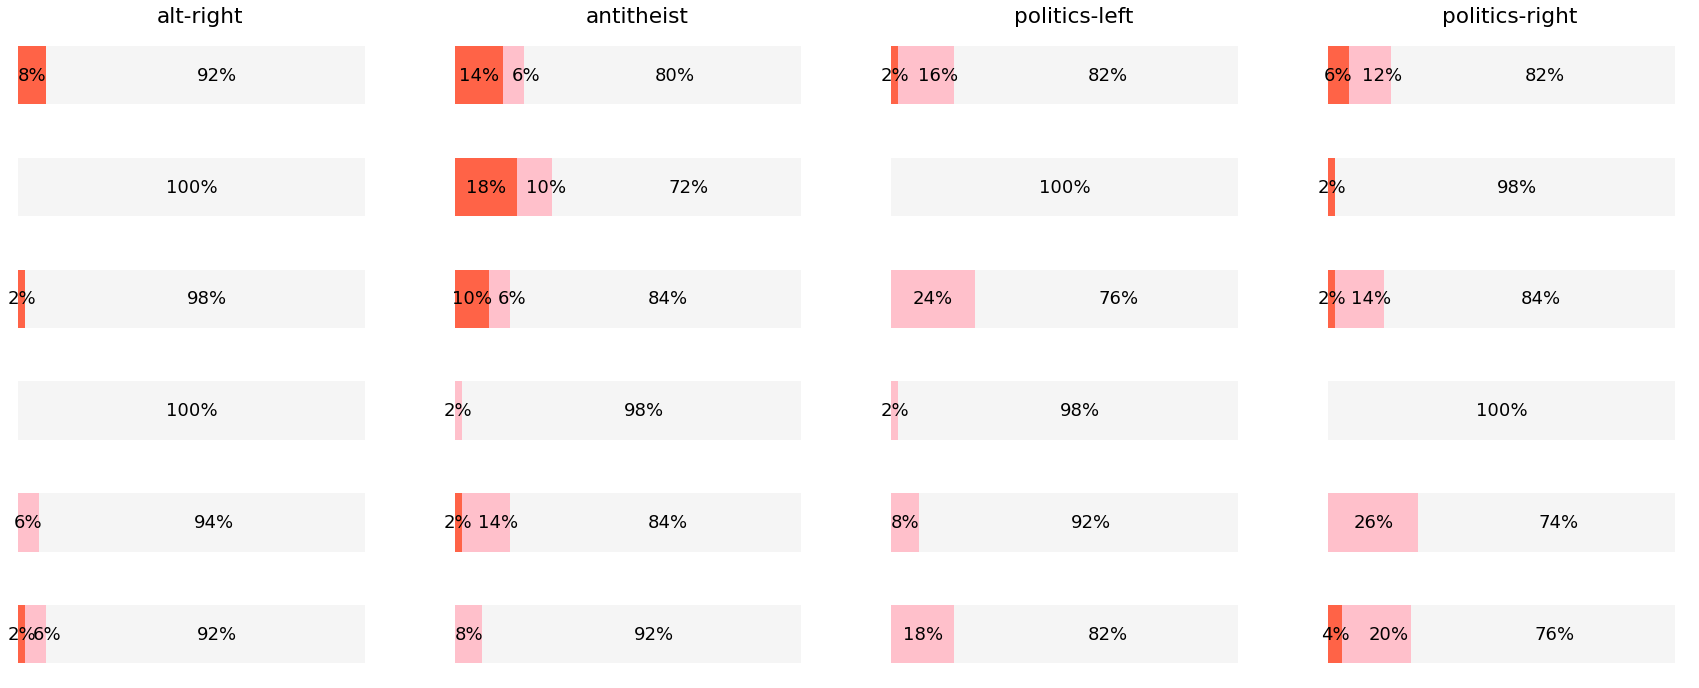

In [273]:
# Source: https://matplotlib.org/stable/gallery/pie_and_polar_charts/bar_of_pie.html
fig, axs = plt.subplots(6, 4, figsize=(30, 12))

for strategy_idx in range(len(axs)):
    # don't use none strategy
    strategy = strategies[1:][strategy_idx]
        
    for topic_idx in range(len(axs[strategy_idx])):
        topic = topics[topic_idx]
        
        ax = axs[strategy_idx][topic_idx]

        ratios = num_p3_scrubbed_final.loc[(strategy,(topic,slice(None)))][topic]
        # This is a hack; we got lucky that the alphabetical order followed our desired order
        ratios = ratios.sort_index(ascending=False)

        # For colors
        i = 0
        prev_width=10
        for j, (width, label) in enumerate([*zip(ratios, ratios.index)]):
            bc = ax.barh(0, width, height, left=left, color=colors[i], label=label)
            if width > 0:
                ax.bar_label(bc, labels=[f"{width:.0%}"], label_type='center', padding=12 if prev_width<10 else 0)
                prev_width=width
            i += 1
            left += width
            

        if strategy_idx==0:
            ax.set_title('{0}'.format(topic))
        ax.axis('off')
        ax.set_ylim(- 0.8 * height, 0.8 * height)

        # Won't work!
        if topic_idx==0:
            #print('yes')
            ax.set_ylabel('{0}'.format(strategy))

        # Dumb- cannot set away from diagrams
        #if strategy_idx==0 and topic_idx==len(axs[strategy_idx])-1:
            #ax.legend(loc = 'upper right')

plt.show()

In [274]:
strategies[1:]

['watch',
 'delete',
 'dislike',
 'not-interested',
 'no-channel',
 'dislike-recommendation']

## MWU tests

In [275]:
df_homepage = df[
    (df['component']=='homepage')&
    (df['exp_stage'].isin([1,2,3]))
]

df_videopage = df[
    (df['component']=='videopage')&
    (df['exp_stage'].isin([1,2,3]))
]

In [276]:
df_videopage['exp_stage'].unique()

array([1, 2, 3])

In [277]:
stain_hp = df_homepage.groupby(['topic','strategy','exp_stage','note'])['on_topic'].agg(
    lambda x: x.sum() / len(x)
)
stain_vp = df_videopage.groupby(['topic','strategy','exp_stage','note'])['on_topic'].agg(
    lambda x: x.sum() / len(x)
)

Normality test (takeaway: Non-normal on more than half of P1/P2; P3 not enough samples (need at least 8 and we have 5 per topic/strategy combo)

In [278]:
stain_hp.loc[(slice(None),slice(None),slice(1,2),slice(None))].groupby(['topic','exp_stage']).agg(
    lambda x: normaltest(x)
)

topic           exp_stage
alt-right       1            (16.800868616769876, 0.00022476968361905054)
                2               (2.2910966731100664, 0.31804947181553206)
antitheist      1               (7.248029265513731, 0.026675369425632194)
                2               (0.39894965049755643, 0.8191608427237733)
politics-left   1              (10.657063714245352, 0.004851187022250121)
                2                 (0.06497962268914118, 0.96803231272874)
politics-right  1               (7.431928322915563, 0.024331969854274067)
                2               (0.09890297699019172, 0.9517513279057819)
Name: on_topic, dtype: object

In [279]:
stain_vp.loc[(slice(None),slice(None),slice(1,2),slice(None))].groupby(['topic','exp_stage']).agg(
    lambda x: normaltest(x)
)

topic           exp_stage
alt-right       1              (11.441998796651049, 0.003276434802096796)
                2            (36.610227961666475, 1.1225094542790655e-08)
antitheist      1                (4.681275393919852, 0.09626622997044798)
                2                (4.647067072800639, 0.09792694510652294)
politics-left   1                (2.4975235330347294, 0.2868597764210318)
                2              (6.6188702758150395, 0.036536806182746226)
politics-right  1               (3.6197870131059755, 0.16367156582387177)
                2                (4.733657908149025, 0.09377762845065406)
Name: on_topic, dtype: object

Paired t-test

In [280]:
def get_sig_t(x):
    p2 = list(x.loc[(slice(None),slice(None),2,)].sort_index())
    p3 = list(x.loc[(slice(None),slice(None),3,)].sort_index())
    print()
    val, p = ttest_rel(p2, p3)
    
    return '{0:.0f}% vs. {1:.0f}%: {2}'.format(np.mean(p2)*100,np.mean(p3)*100,p)

In [281]:
stain_hp.loc[(slice(None),slice(None),slice(2,3),slice(None))].groupby(['strategy']).agg(
    lambda x: get_sig_t(x)
)

strategy
delete                     26% vs. 8%: 2.1362304427543192e-05
dislike                      25% vs. 15%: 0.01678612147575504
dislike-recommendation     28% vs. 14%: 0.0027307845482946146
no-channel                33% vs. 14%: 1.0923209808834117e-06
none                        25% vs. 32%: 0.028181664310278933
not-interested              27% vs. 1%: 3.961434223366484e-09
watch                       25% vs. 16%: 0.020080638790965482
Name: on_topic, dtype: object

In [282]:
# P1 points seem to be non-normal, and P2 points seem to be normal (at least cannot reject the null)

In [283]:
def get_significant_mwu(x):
    p1 = list(x.loc[(slice(None),slice(None),1,)])
    p2 = list(x.loc[(slice(None),slice(None),2,)])
    p3 = list(x.loc[(slice(None),slice(None),3,)])
    
    # C
    u_12, mwu_12 = mannwhitneyu(list(p1),list(p2), alternative='less')
    u_23, mwu_23 = mannwhitneyu(list(p2),list(p3), alternative='greater')
    
    str_12 = '     '
    str_23 = '     '
    threshold = 0.05
    if mwu_12 < threshold:
        str_12 = '***'
    if mwu_23 < threshold:
        str_23 = '***'
    return '{0:.0f}%{1}{2:.0f}%{3}{4:.0f}%'.format(np.mean(p1)*100, str_12, np.mean(p2)*100, str_23, np.mean(p3)*100)





In [284]:
def get_significant_mwu_2(x, do_12):
    p1 = list(x.loc[(slice(None),slice(None),1,)])
    p2 = list(x.loc[(slice(None),slice(None),2,)])
    p3 = list(x.loc[(slice(None),slice(None),3,)])
    
    u_12, mwu_12 = mannwhitneyu(list(p1),list(p2), alternative='less')
    u_23, mwu_23 = mannwhitneyu(list(p2),list(p3), alternative='greater')

    threshold = 0.05
    
    if do_12:

        return {
            'p1': '{0:.0f}%'.format(round(np.mean(p1)*100)),
            '12sig': '***' if mwu_12 < threshold else '   ',
            'p2': '{0:.0f}%'.format(round(np.mean(p2)*100)),
            '23_sig': '',
            'p3': ''
        }
    
    else:
        return {
            'p1': '',
            '12sig': '',
            'p2': '{0:.0f}%'.format(round(np.mean(p2)*100)),
            '23_sig': '***' if mwu_23 < threshold else '   ',
            'p3': '{0:.0f}%'.format(round(np.mean(p3)*100))
        }

In [285]:
def get_average_diff(x):
    #print(x)
    all_diffs = []
    for t in topics:
        num = np.mean(x.loc[(t,slice(None),3,)])
        den = np.mean(x.loc[(t,slice(None),2,)])
        if den == 0:
            all_diffs.append(0)
        else:
            all_diffs.append( (num / den) - 1 )
    return '{0:.0f}%'.format(round(np.mean(all_diffs)*100))

In [286]:
pd.options.display.max_columns = 100


In [287]:
mwu_df_hp = stain_hp.groupby(['strategy','topic']).apply(
    lambda x: get_significant_mwu_2(x, do_12=False)
)
mwu_df_hp = mwu_df_hp.reset_index().rename(columns={'level_2':'metric'})

topic_mwu_hp = stain_hp.groupby(['topic']).apply(
    lambda x: get_significant_mwu_2(x, do_12=True)
)
topic_mwu_hp = topic_mwu_hp.reset_index().rename(columns={'level_1':'metric'})
topic_mwu_hp['strategy'] = ['total' for i in range(topic_mwu_hp.shape[0])]

strategy_mwu_hp = stain_hp.groupby(['strategy']).apply(
    get_average_diff
)
strategy_mwu_hp = strategy_mwu_hp.reset_index()
strategy_mwu_hp['topic'] = ['average' for i in range(strategy_mwu_hp.shape[0])]
strategy_mwu_hp['metric'] = ['23change' for i in range(strategy_mwu_hp.shape[0])]

mwu_hp_final = pd.concat([mwu_df_hp,topic_mwu_hp,strategy_mwu_hp],axis=0).set_index(
    ['topic','strategy','metric']
).unstack([0,2]).loc[['total']+strategies].fillna('')
mwu_hp_final

on_topic                                               \
topic                  alt-right                        antitheist              
metric                        p1 12sig   p2 23_sig   p3         p1 12sig   p2   
strategy                                                                        
total                         2%   ***  18%                    10%   ***  36%   
none                                    20%         22%                   30%   
watch                                   10%          8%                   34%   
delete                                  18%    ***   0%                   34%   
dislike                                 18%    ***   2%                   34%   
not-interested                          16%    ***   0%                   38%   
no-channel                              26%    ***   6%                   44%   
dislike-recommendation                  20%    ***   8%                   36%   

                                                                         \
topic                              politics-left                          
metric                 23_sig   p3            p1 12sig   p2 23_sig   p3   
strategy                                                                  
total                                         8%   ***  25%               
none                           44%                      18%         26%   
watch                          20%                      26%         18%   
delete                         28%                      24%    ***   0%   
dislike                   ***  16%                      22%         24%   
not-interested            ***   2%                      24%    ***   2%   
no-channel                ***  16%                      28%    ***   8%   
dislike-recommendation    ***   8%                      30%         18%   

                                                                       
topic                  politics-right                         average  
metric                             p1 12sig   p2 23_sig   p3 23change  
strategy                                                               
total                              9%   ***  29%                       
none                                         33%         35%      27%  
watch                                        30%         18%     -33%  
delete                                       30%    ***   2%     -78%  
dislike                                      26%         16%     -43%  
not-interested                               30%    ***   0%     -97%  
no-channel                                   34%         26%     -59%  
dislike-recommendation                       24%         24%     -44%

In [288]:
mwu_hp_final.to_csv('./tables/mwu_hp_final.csv')

In [289]:
mwu_df_vp = stain_vp.groupby(['strategy','topic']).apply(
    lambda x: get_significant_mwu_2(x, do_12=False)
)
mwu_df_vp = mwu_df_vp.reset_index().rename(columns={'level_2':'metric'})

topic_mwu_vp = stain_vp.groupby(['topic']).apply(
    lambda x: get_significant_mwu_2(x, do_12=True)
)
topic_mwu_vp = topic_mwu_vp.reset_index().rename(columns={'level_1':'metric'})
topic_mwu_vp['strategy'] = ['total' for i in range(topic_mwu_vp.shape[0])]

strategy_mwu_vp = stain_vp.groupby(['strategy']).apply(
    get_average_diff
)
strategy_mwu_vp = strategy_mwu_vp.reset_index()
strategy_mwu_vp['topic'] = ['average' for i in range(strategy_mwu_vp.shape[0])]
strategy_mwu_vp['metric'] = ['23change' for i in range(strategy_mwu_vp.shape[0])]

mwu_vp_final = pd.concat([mwu_df_vp,topic_mwu_vp,strategy_mwu_vp],axis=0).set_index(
    ['topic','strategy','metric']
).unstack([0,2]).loc[['total']+strategies].fillna('')
mwu_vp_final


on_topic                                               \
topic                  alt-right                        antitheist              
metric                        p1 12sig   p2 23_sig   p3         p1 12sig   p2   
strategy                                                                        
total                         6%         5%                    20%        18%   
none                                     6%          4%                   20%   
watch                                    4%          6%                    8%   
delete                                   2%          2%                   24%   
dislike                                 10%         14%                   12%   
not-interested                           4%          2%                   24%   
no-channel                               0%          0%                   24%   
dislike-recommendation                   6%          2%                   16%   

                                                                         \
topic                              politics-left                          
metric                 23_sig   p3            p1 12sig   p2 23_sig   p3   
strategy                                                                  
total                                        40%        31%               
none                           28%                      26%         18%   
watch                           6%                      32%         36%   
delete                         28%                      28%         34%   
dislike                         4%                      36%         38%   
not-interested                 40%                      32%         32%   
no-channel                     28%                      34%         28%   
dislike-recommendation         20%                      30%         28%   

                                                                       
topic                  politics-right                         average  
metric                             p1 12sig   p2 23_sig   p3 23change  
strategy                                                               
total                             15%   ***  25%                       
none                                         18%         30%      12%  
watch                                        28%         28%       9%  
delete                                       30%         18%       0%  
dislike                                      24%         40%      11%  
not-interested                               26%         28%       6%  
no-channel                                   26%         22%      -4%  
dislike-recommendation                       20%         18%     -15%

In [290]:
mwu_vp_final.to_csv('./tables/mwu_vp_final.csv')

## Filter bubble analysis
- Do recommendations get more than half? 
- Yes, but rarely (3/139 for homepage, 8/139 for videopage)

In [291]:
stain_vp[(slice(None),slice(None),2,slice(None))].value_counts()

0.0    48
0.1    24
0.2    17
0.3    15
0.4    14
0.5    13
0.6     7
0.7     1
Name: on_topic, dtype: int64

In [292]:
len(stain_vp[(slice(None),slice(None),2,slice(None))])

139

### [2/15] Wilcoxon Signed Rank Test

In [293]:
def get_wilcoxon(x):
    p1 = list(x.loc[(slice(None),slice(None),1,)].sort_index())
    p2 = list(x.loc[(slice(None),slice(None),2,)].sort_index())
    p3 = list(x.loc[(slice(None),slice(None),3,)].sort_index())
    
    #print(pd.DataFrame({'p2,p3))
    
    res = wilcoxon(x=p2, y=p3, alternative='greater')
    
    print('{0}, {1}, {2}'.format(list(x.reset_index()['strategy'])[0], res.statistic, res.pvalue))

In [305]:
stain_hp

topic           strategy  exp_stage  note
alt-right       delete    1          0       0.1
                                     1       0.0
                                     2       0.1
                                     3       0.0
                                     4       0.0
                                            ... 
politics-right  watch     3          0       0.1
                                     1       0.1
                                     2       0.4
                                     3       0.1
                                     4       0.2
Name: on_topic, Length: 417, dtype: float64

In [306]:
stain_hp_2 = stain_hp.reset_index()
stain_hp_2_list = stain_hp_2[
    (stain_hp_2['exp_stage']==2)
].sort_values(['topic','strategy','note'])['on_topic']

stain_hp_3 = stain_hp.reset_index()
stain_hp_3_list = stain_hp_3[
    (stain_hp_3['exp_stage']==3)
].sort_values(['topic','strategy','note'])['on_topic']

mwu_df_hp = stain_hp.groupby(['strategy']).apply(
    lambda x: get_wilcoxon(x)
)

delete, 152.0, 0.00016141407008173433
dislike, 113.5, 0.008926922269729713
dislike-recommendation, 121.5, 0.0026483996600820516
no-channel, 169.5, 0.00011839480660932648
none, 6.5, 0.9910830264704327
not-interested, 210.0, 9.5367431640625e-07
watch, 94.5, 0.024314449565249866


/Users/avliu/opt/anaconda3/envs/scrub-analysis/lib/python3.10/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/avliu/opt/anaconda3/envs/scrub-analysis/lib/python3.10/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/avliu/opt/anaconda3/envs/scrub-analysis/lib/python3.10/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/avliu/opt/anaconda3/envs/scrub-analysis/lib/python3.10/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculat

In [307]:
stain_vp

topic           strategy  exp_stage  note
alt-right       delete    1          0       0.0
                                     1       0.2
                                     2       0.0
                                     3       0.0
                                     4       0.1
                                            ... 
politics-right  watch     3          0       0.2
                                     1       0.1
                                     2       0.3
                                     3       0.5
                                     4       0.3
Name: on_topic, Length: 416, dtype: float64

In [304]:
mwu_df_vp = stain_vp.groupby(['strategy']).apply(
    lambda x: get_wilcoxon(x)
)

delete, 46.5, 0.4720313084491938


/Users/avliu/opt/anaconda3/envs/scrub-analysis/lib/python3.10/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


ValueError: The samples x and y must have the same length.

In [296]:
# --> All changes, except none, were significant

Same as above, but with videopage

Comparing not-interested with other strategies in the homepage

In [297]:
hp_last = stain_hp.loc[(slice(None),slice(None),3,slice(None))]
hp_last

topic           strategy  note
alt-right       delete    0       0.0
                          1       0.0
                          2       0.0
                          3       0.0
                          4       0.0
                                 ... 
politics-right  watch     0       0.1
                          1       0.1
                          2       0.4
                          3       0.1
                          4       0.2
Name: on_topic, Length: 139, dtype: float64

In [298]:
def get_wilcoxon_2(x):
    p_other = list(x['on_topic_other'].sort_index())
    p_this = list(x['on_topic'].sort_index())
    
    #print(pd.DataFrame({'p2,p3))
    
    res = wilcoxon(x=p_other, y=p_this, alternative='greater')
    
    threshold = 0.05
    
    print('{0}, {1}, {2}'.format(list(x.reset_index()['strategy'])[0], res.statistic, res.pvalue))
    
    return res.pvalue < threshold

In [299]:
cols = list(hp_last.reset_index()['strategy'].unique())
cols

['delete',
 'dislike',
 'dislike-recommendation',
 'no-channel',
 'none',
 'not-interested',
 'watch']

In [300]:
results = {}

for this_col in cols:
    print()
    print(this_col)

    other_cols = list(hp_last.reset_index()['strategy'].unique())
    other_cols.remove(this_col)

    this_hp = hp_last.loc[(slice(None),this_col,slice(None),slice(None))]

    comp = hp_last.loc[(slice(None),other_cols,slice(None),slice(None))].to_frame().join(this_hp, lsuffix='_other')

    comp_results = comp.groupby(['strategy'])[['on_topic_other','on_topic']].apply(
        lambda x: get_wilcoxon_2(x)
    )
    results[this_col] = comp_results.to_dict()

/Users/avliu/opt/anaconda3/envs/scrub-analysis/lib/python3.10/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/avliu/opt/anaconda3/envs/scrub-analysis/lib/python3.10/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/avliu/opt/anaconda3/envs/scrub-analysis/lib/python3.10/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/avliu/opt/anaconda3/envs/scrub-analysis/lib/python3.10/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculat


delete
dislike, 87.5, 0.05766915639748575
dislike-recommendation, 97.0, 0.0657257337602366
no-channel, 97.5, 0.06134602123549751
none, 188.5, 5.7220458984375e-06
not-interested, 1.5, 0.9711102144382013
watch, 100.0, 0.010354181725088256

dislike
delete, 32.5, 0.9423308436025143
dislike-recommendation, 40.5, 0.6378742557350316
no-channel, 39.5, 0.6642650606639885
none, 128.5, 0.0008525402908213306
not-interested, 0.0, 0.9995843945283095
watch, 29.5, 0.20118162220946928

dislike-recommendation
delete, 39.0, 0.9342742662397634
dislike, 50.5, 0.36212574426496835
no-channel, 45.0, 0.514101801652164
none, 129.0, 0.0007887125732598213
not-interested, 3.5, 0.9994185985019935
watch, 85.0, 0.1860421350766156

no-channel
delete, 38.5, 0.9386539787645025
dislike, 51.5, 0.3357349393360115
dislike-recommendation, 46.0, 0.485898198347836
none, 136.0, 0.00020747839095166336
not-interested, 0.0, 0.9998371248473562
watch, 92.0, 0.1024390491609461

none
delete, 1.5, 0.9999990463256836
dislike, 7.5, 0.99

/Users/avliu/opt/anaconda3/envs/scrub-analysis/lib/python3.10/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/avliu/opt/anaconda3/envs/scrub-analysis/lib/python3.10/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/avliu/opt/anaconda3/envs/scrub-analysis/lib/python3.10/site-packages/scipy/stats/morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/Users/avliu/opt/anaconda3/envs/scrub-analysis/lib/python3.10/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to n

In [301]:
cols_ordered = [
    'none',
    'watch',
    'delete',
    'dislike',
    'not-interested',
    'no-channel',
    'dislike-recommendation'
]


pd.DataFrame(results).loc[cols_ordered,cols_ordered].replace({True:'*',False:'',pd.NA:'--'})

,none,watch,delete,dislike,not-interested,no-channel,dislike-recommendation
none,--,*,*,*,*,*,*
watch,,--,*,,*,,
delete,,,--,,*,,
dislike,,,,--,*,,
not-interested,,,,,--,,
no-channel,,,,,*,--,
dislike-recommendation,,,,,*,,--


In [302]:
# ^ How to read: Row strategy is the "reference". 
# Column strategy is the one we want to see if is "better", i.e. produces stain % signifiantly less than the reference
# --> Not-interested is clearly "better" than every other strategy